In [1]:
import paths as paths
import shared.locals as locals
from tinydb.queries import where
from datetime import datetime, timedelta
from database.models import Commit, ErrorLog, Project
from database.database import Database
from shared.calculation import query_and_calculate_ownership

database = Database(paths.DATABASE_PATH, cached=True)
results = {"deviating": {}, "equivalent": {}}
dates = set()

project = database.query(Project.LABEL, where("id") == 5584)[0]
commits = database.query(Commit.LABEL, where("project_id") == project.id)
result = {
    "general": {},
    "author": {},
    "commits": len(commits),
    "authors": len({commit.author_id for commit in commits})
}

errors = database.query(ErrorLog.LABEL,
    (where("account") == "production") &
    (where("loggroup").one_of(project.log_groups)) &
    (where("author_id") != None))
deviation = False

for error in errors:
    ownership_general = query_and_calculate_ownership(database, project.id, error.timestamp)
    ownership_author = query_and_calculate_ownership(database, project.id, error.timestamp, author=error.author_id)

    if ownership_general != ownership_author:
        deviation = True

    dt = datetime.utcfromtimestamp(error.timestamp)
    dates.add(dt.date())

    result["general"][dt] = ownership_general
    result["author"][dt] = ownership_author

years = {date.year for date in dates}

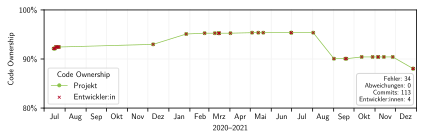

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

plt.rc("font", **locals.FONT)

fig, ax = plt.subplots(figsize=(locals.TEXTWIDTH, 2))

general_sorted = dict(sorted(result["general"].items()))
author_sorted = dict(sorted(result["author"].items()))

ax.plot(list(general_sorted.keys()), list(general_sorted.values()), zorder=2,
    color=locals.MATERIAL_COLORS["lightgreen"], marker=".", linewidth=0.7, label="Projekt")
ax.scatter(list(author_sorted.keys()), list(author_sorted.values()), zorder=3,
    color=locals.ERROR_COLOR_RED, marker="x", s=8, linewidth=0.7, label="Entwickler:in")

ax.legend(loc="lower left", title="Code Ownership", edgecolor=locals.FRAME_GRAY)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(mticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0, decimals=0))
ax.tick_params(axis="x", which="minor", bottom=False, top=False, labelbottom=True)

ax.margins(x=0.02)
ax.set_xlabel(f"{min(years)}–{max(years)}")
ax.set_ylabel("Code Ownership")
ax.set_xlim([min(dates).replace(day=1), max(dates) + timedelta(days=5)])
ax.set_ylim([0.8, 1.0])
ax.set_yticks([0.8, 0.9, 1.0])
ax.grid(color=locals.GRID_GRAY)
ax.set_axisbelow(True)

annotation = f"Fehler: {len(general_sorted)}"

general_values = list(general_sorted.values())
author_values = list(author_sorted.values())
deviation = 0
for i in range(len(list(general_sorted.values()))):
    if general_values[i] != author_values[i]:
        deviation += 1
annotation += f"\nAbweichungen: {deviation}"

annotation += f"\nCommits: {result['commits']}"
annotation += f"\nEntwickler:innen: {result['authors']}"

props = dict(boxstyle="round", facecolor="white", edgecolor=locals.FRAME_GRAY, pad=0.4)
ax.text(0.985, 0.056, annotation, fontsize="small", bbox=props,
    horizontalalignment="right", verticalalignment="bottom", transform=ax.transAxes)

plt.tight_layout()
plt.show()